# Исследование по метрикам на основе данных моего произношения

## Импорт библиотеки

In [203]:
# Для взаимодействия с системой
import sys
import os
import re
# Для работы с массивами чисел
import numpy as np 
# Для оценки качества распознавания речи
from jiwer import wer, cer, mer, wil
# Для вычисления расстояния Левенштейна
import Levenshtein
# Для статистического анализа данных
from scipy.stats import pearsonr, linregress
from statsmodels.tsa.stattools import adfuller
import pymannkendall as mk
# Для работы с базами данных PostgreSQL
import psycopg2
# Для работы с данными в формате DataFrame
import pandas as pd
# Для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sb
# Для работы со звуковыми файлами
import io
import soundfile as sf
import librosa
# Для обработки естественного языка
import nltk
import string
from nltk.stem import WordNetLemmatizer
# Для работы с различными сервисами распознавания речи
from AutomaticSpeechRecognitionYandex import AutomaticSpeechRecognitionYandex
from AutomaticSpeechRecognitionSaluteSpeech import AutomaticSpeechRecognitionSaluteSpeech
from AutomaticSpeechRecognitionMBART50 import AutomaticSpeechRecognitionMBART50

from tokens import FOLDER_ID, OAUTH, CLIENT_ID, CLIENT_SECRET

## Загрузка данных с БД

In [2]:
# Сбор список слов
from sentences_text import sentences_text

### Коллекция слов

In [3]:
for theme, words in sentences_text.items():
    print(f"Тема: {theme}")
    print("Предложение:", words)
    print("\n")

Тема: Искусственный интеллект
Предложение: Искусственный интеллект (ИИ) - это область компьютерных наук, создающая системы для выполнения задач, требующих человеческого интеллекта: распознавание речи, обработка изображений, принятие решений. Искусственный интеллект проникает во все сферы жизни, от рекомендаций в онлайн-магазинах до медицинских диагнозов.

Главное преимущество ИИ - способность обрабатывать большие объемы данных и выявлять закономерности. В медицине он помогает диагностировать заболевания, анализируя снимки и историю болезни. В бизнесе искусственный интеллект используется для прогнозирования рынка, оптимизации цепочек поставок и автоматизации процессов.

ИИ базируется на алгоритмах машинного обучения, позволяющих системам обучаться на основе данных. Современные ИИ-системы используют глубокие нейронные сети, имитирующие работу мозга. Для разработки таких моделей требуются мощные вычислительные ресурсы и инструменты, такие как TensorFlow и PyTorch.

Искусственный интеллект

## Анализ данных

In [4]:
df = pd.read_csv('database_preprocessing_metric.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_date                   461 non-null    object 
 1   id                            461 non-null    int64  
 2   topic                         461 non-null    object 
 3   paragraph_text                461 non-null    object 
 4   transcript_text_yandex        453 non-null    object 
 5   transcript_text_salutespeech  431 non-null    object 
 6   transcript_text_mbart50       461 non-null    object 
 7   voice_recording               461 non-null    object 
 8   lemmatized_text               461 non-null    object 
 9   WER_yandex                    453 non-null    float64
 10  CER_yandex                    453 non-null    float64
 11  MER_yandex                    453 non-null    float64
 12  WIL_yandex                    453 non-null    float64
 13  Leven

In [6]:
df.head()

,record_date,id,topic,paragraph_text,transcript_text_yandex,transcript_text_salutespeech,transcript_text_mbart50,voice_recording,lemmatized_text,WER_yandex,...,WER_salutespeech,CER_salutespeech,MER_salutespeech,WIL_salutespeech,Levenshtein_salutespeech,WER_mbart50,CER_mbart50,MER_mbart50,WIL_mbart50,Levenshtein_mbart50
0,2024-06-15,1,Искусственный интеллект,Искусственный интеллект (ИИ) - это область ком...,Искусственный интеллект это вопрос компьютерны...,NaN,"едивствительный характер, а то я, попросту, ко...",<memory at 0x7721cea20040>,искусственный интеллект ии это область компьют...,0.861,...,NaN,NaN,NaN,NaN,NaN,0.944,0.703,0.944,0.996,220.0
1,2024-06-15,2,Искусственный интеллект,Главное преимущество ИИ - способность обрабаты...,Структурный тракт Трапающий тракт Так из за по...,Осуществлённый тракт от оплаты компьютерных но...,"здесь копустимный тракт, а то просит купечески...",<memory at 0x7721cea201c0>,главное преимущество ии способность обрабатыва...,1.000,...,1.000,0.739,1.000,1.000,235.0,0.973,0.748,0.973,0.999,238.0
2,2024-06-15,4,Искусственный интеллект,ИИ базируется на алгоритмах машинного обучения...,Секс интеллект позируется на алгоритмах машина...,Интеллект позируется на алгоритмах машины появ...,"здесь к примеру интеллигент, пояснивая причину...",<memory at 0x7721cea20100>,ии базируется на алгоритмах машинного обучения...,0.889,...,0.806,0.566,0.806,0.938,168.0,0.917,0.694,0.868,0.975,206.0
3,2024-06-15,5,Искусственный интеллект,Искусственный интеллект - революционная технол...,Рвотчины технари мнящие мир и проносящие на че...,"Эффект революционный техногии, меняющий мир, п...","они киллект, революция, тихонги, мне очень яны...",<memory at 0x7721cea20580>,искусственный интеллект революционная технолог...,0.682,...,0.864,0.467,0.864,0.971,155.0,0.932,0.639,0.932,0.995,212.0
4,2024-06-16,6,Искусственный интеллект,Искусственный интеллект (ИИ) - это область ком...,Интеллект Видать трепающий челябинского интелл...,"Интеллект компьютерных наук, состоящих материа...","безопасный интеллект, дай-капитатурных наок, р...",<memory at 0x7721ceb625c0>,искусственный интеллект ии это область компьют...,0.833,...,0.778,0.355,0.778,0.934,111.0,1.000,0.652,1.000,1.000,204.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_date                   461 non-null    object 
 1   id                            461 non-null    int64  
 2   topic                         461 non-null    object 
 3   paragraph_text                461 non-null    object 
 4   transcript_text_yandex        453 non-null    object 
 5   transcript_text_salutespeech  431 non-null    object 
 6   transcript_text_mbart50       461 non-null    object 
 7   voice_recording               461 non-null    object 
 8   lemmatized_text               461 non-null    object 
 9   WER_yandex                    453 non-null    float64
 10  CER_yandex                    453 non-null    float64
 11  MER_yandex                    453 non-null    float64
 12  WIL_yandex                    453 non-null    float64
 13  Leven

In [8]:
# Преобразуем значения в столбце 'record_date' в datetime.date
df['record_date'] = df['record_date'].apply(lambda x: pd.Timestamp(x).date())

In [9]:
# Задаем начальную и конечную даты для фильтрации
start_date = pd.Timestamp('2024-06-16').date()
end_date = pd.Timestamp('2024-08-20').date()

In [10]:
# Преобразуем индексы MultiIndex в датафрейме к типу datetime64 для временной фильтрации
df_filtered = df.loc[(df['record_date'] >= start_date) & (df['record_date'] <= end_date)]

In [11]:
# Сгруппируем по датам и ID
df_filtered = df_filtered.groupby(['record_date', 'id']).sum()

In [12]:
df_filtered.head()

topic  \
record_date id                            
2024-06-16  6   Искусственный интеллект   
            7   Искусственный интеллект   
            8   Искусственный интеллект   
            9                 Веб-сокет   
            10                Веб-сокет   

                                                   paragraph_text  \
record_date id                                                      
2024-06-16  6   Искусственный интеллект (ИИ) - это область ком...   
            7   Главное преимущество ИИ - способность обрабаты...   
            8   ИИ базируется на алгоритмах машинного обучения...   
            9   Веб-сокеты - это технология для обмена данными...   
            10  Главное преимущество веб-сокетов - поддержка п...   

                                           transcript_text_yandex  \
record_date id                                                      
2024-06-16  6   Интеллект Видать трепающий челябинского интелл...   
            7   Степощепанник обрабатывает пращи о примыканиях...   
            8   Исключительный интеллект революционные техноло...   
            9   Технология Мы не станем выраженным равномерным...   
            10  Го мне прымщ тебя высек эта поддержка штейна в...   

                                     transcript_text_salutespeech  \
record_date id                                                      
2024-06-16  6   Интеллект компьютерных наук, состоящих материа...   
            7                                                   0   
            8   Искусственный интеллект, революционные техноло...   
            9    В отличие от этой перезапросом и всякой обесп...   
            10  Да, мне пришло вот это поддержка почтенного св...   

                                          transcript_text_mbart50  \
record_date id                                                      
2024-06-16  6   безопасный интеллект, дай-капитатурных наок, р...   
            7   голубнеж тунеядцы, стипендиаты, стипендистки, ...   
            8   здесь к счастью, интеллигенты, ловящие на них ...   
            9   ибо, посяки эти, как ты нравы, мы не таны, мы ...   
            10  голубня, прыгнув тебе, джигурка, это поддержка...   

                           voice_recording  \
record_date id                               
2024-06-16  6   <memory at 0x7721ceb625c0>   
            7   <memory at 0x7721ceb63a00>   
            8   <memory at 0x7721ceb63c40>   
            9   <memory at 0x7721ceb63e80>   
            10  <memory at 0x7721ceb63b80>   

                                                  lemmatized_text  WER_yandex  \
record_date id                                                                  
2024-06-16  6   искусственный интеллект ии это область компьют...       0.833   
            7   главное преимущество ии способность обрабатыва...       0.811   
            8   ии базируется на алгоритмах машинного обучения...       1.250   
            9   вебсокеты это технология для обмена данными в ...       0.861   
            10  главное преимущество вебсокетов поддержка пост...       0.829   

                CER_yandex  MER_yandex  ...  WER_salutespeech  \
record_date id                          ...                     
2024-06-16  6        0.486       0.811  ...             0.778   
            7        0.491       0.811  ...             0.000   
            8        0.886       0.978  ...             1.000   
            9        0.639       0.861  ...             0.833   
            10       0.601       0.773  ...             0.610   

                CER_salutespeech  MER_salutespeech  WIL_salutespeech  \
record_date id                                                         
2024-06-16  6              0.355             0.778             0.934   
            7              0.000             0.000             0.000   
            8              0.774             1.000             1.000   
            9              0.544             0.833             0.957   
            10   

/tmp/ipykernel_1023082/2220433589.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_metrics = daily_metrics.fillna(method='ffill')


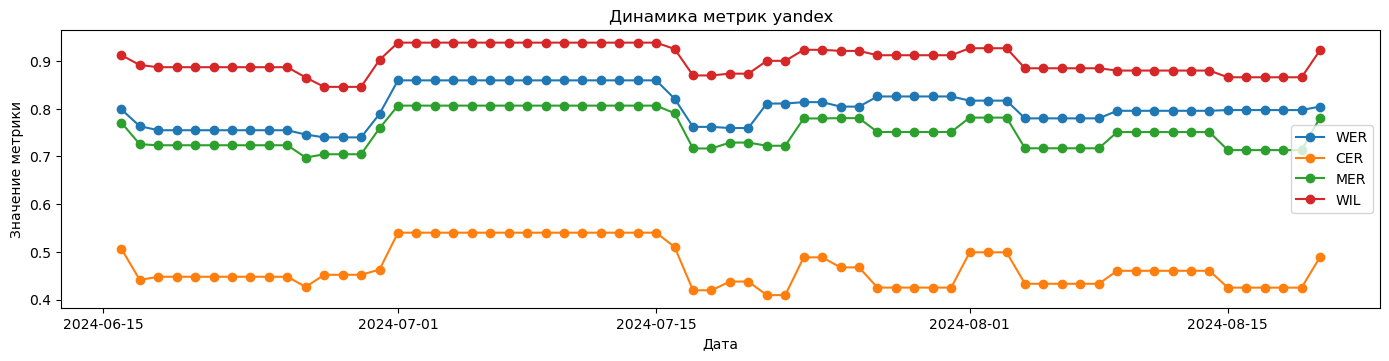

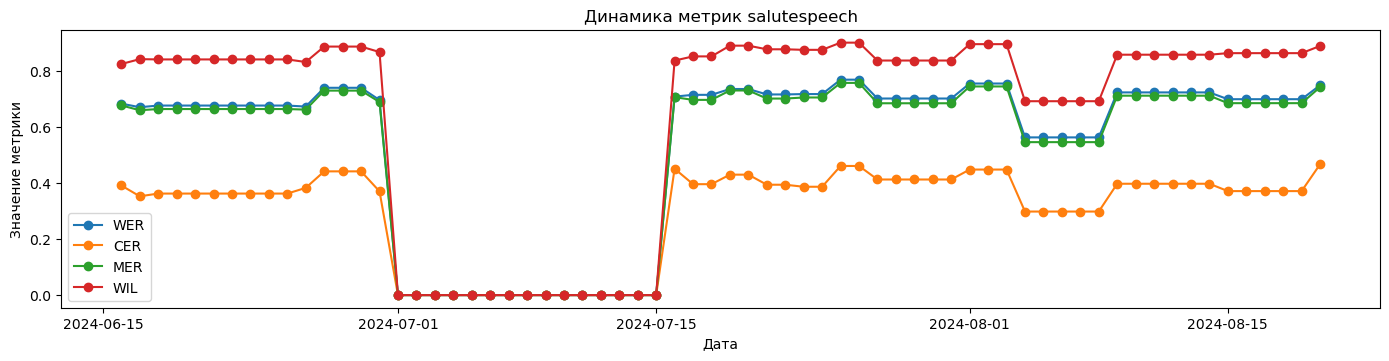

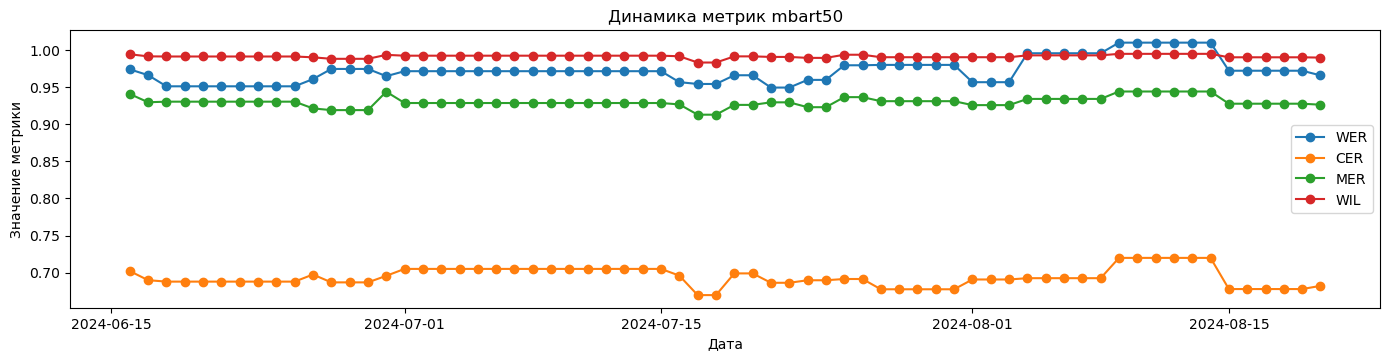

In [13]:
# Преобразуем первый уровень MultiIndex (даты) в DatetimeIndex
df_filtered.index = pd.to_datetime(df_filtered.index.get_level_values(0))

# Оставляем только числовые столбцы для группировки и агрегации
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64'])

# Устраняем дубликаты по дате, агрегируя их средним значением
df_filtered_numeric = numeric_columns.groupby(df_filtered.index).mean()

# Агрегируем метрики по дням, заполняя пропуски
daily_metrics = df_filtered_numeric.resample('D').asfreq()

# Заполняем пропуски методом ffill (линейно от предыдущих значений)
daily_metrics = daily_metrics.fillna(method='ffill')
# Заполняем пропуски нулями
# daily_metrics = daily_metrics.fillna(0)

# Функция для создания графика динамики по метрикам для одной модели
def plot_model_metrics(model_name):
    plt.figure(figsize=(14, 10))

    # WER, CER, MER, WIL, Levenshtein
    plt.subplot(3, 1, 1)
    plt.plot(daily_metrics.index, daily_metrics[f'WER_{model_name}'], label=f'WER', marker='o')
    plt.plot(daily_metrics.index, daily_metrics[f'CER_{model_name}'], label=f'CER', marker='o')
    plt.plot(daily_metrics.index, daily_metrics[f'MER_{model_name}'], label=f'MER', marker='o')
    plt.plot(daily_metrics.index, daily_metrics[f'WIL_{model_name}'], label=f'WIL', marker='o')
    # plt.plot(daily_metrics.index, daily_metrics[f'Levenshtein_{model_name}'], label=f'Levenshtein {model_name}', marker='o')
    plt.title(f'Динамика метрик {model_name}')
    plt.xlabel('Дата')
    plt.ylabel('Значение метрики')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Построение графиков для каждой модели
models = ['yandex', 'salutespeech', 'mbart50']

for model in models:
    plot_model_metrics(model)

### Визуализация динамики метрик

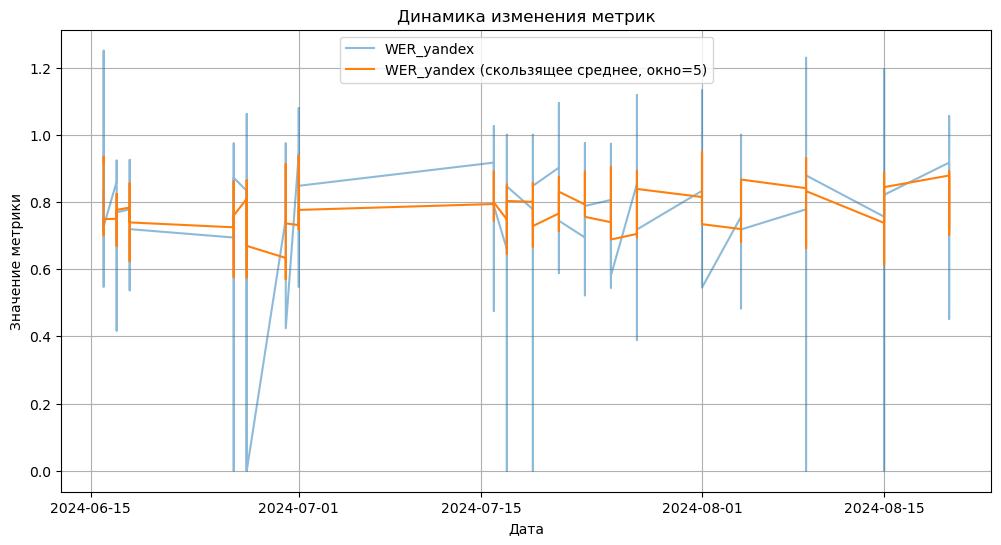

In [14]:
def plot_metrics(df, metrics, window=10): # Добавляем параметр window для размера окна
    df.index = pd.to_datetime(df.index.get_level_values(0))
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(df.index, df[metric], label=metric, alpha=0.5)  # Построение графика исходных данных
        plt.plot(df.index, df[metric].rolling(window=window).mean(), label=f'{metric} (скользящее среднее, окно={window})')  # Построение скользящего среднего
    plt.xlabel('Дата')
    plt.ylabel('Значение метрики')
    plt.title('Динамика изменения метрик')
    plt.legend()
    plt.grid(True)
    plt.show()

# Отображаем динамику по метрикам Yandex
# metrics = ['WER_yandex', 'CER_yandex', 'MER_yandex', 'WIL_yandex']
metrics = ['WER_yandex']
# metrics = ['CER_yandex']
start_date = pd.Timestamp('2024-06-15').date()
end_date = pd.Timestamp('2024-08-20').date()
# plot_metrics(df.loc[(df['record_date'] >= start_date) & (df['record_date'] <= end_date)], metrics, window=5)
plot_metrics(df_filtered, metrics, window=5)

## Математический анализ

In [15]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457 entries, 2024-06-16 to 2024-08-20
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   topic                         457 non-null    object 
 1   paragraph_text                457 non-null    object 
 2   transcript_text_yandex        457 non-null    object 
 3   transcript_text_salutespeech  457 non-null    object 
 4   transcript_text_mbart50       457 non-null    object 
 5   voice_recording               457 non-null    object 
 6   lemmatized_text               457 non-null    object 
 7   WER_yandex                    457 non-null    float64
 8   CER_yandex                    457 non-null    float64
 9   MER_yandex                    457 non-null    float64
 10  WIL_yandex                    457 non-null    float64
 11  Levenshtein_yandex            457 non-null    float64
 12  WER_salutespeech              457 non-null   

In [16]:
models = ['yandex', 'salutespeech', 'mbart50']
metrics = ['WER', 'CER', 'MER', 'WIL']

In [69]:
def calculate_average_metrics(df, rounding=3):
    """Вычисляет средние значения по всем метрикам моделей и возвращает новый DataFrame."""
    
    average_metrics = {}
    for model in models:
        average_metrics[model] = {}
        for metric in metrics:
            column_name = f"{metric}_{model}"
            if column_name in df.columns:
                average_metrics[model][metric] = round(df[column_name].mean() * 100, rounding)
    
    df_average_metrics = pd.DataFrame(average_metrics).transpose()

    # Добавляем столбец с рейтингом
    df_average_metrics['Рейтинг'] = df_average_metrics.mean(axis=1).rank(ascending=True).astype(int)

    # Сортируем по рейтингу по убыванию
    df_average_metrics = df_average_metrics.sort_values(by='Рейтинг', ascending=True)
    
    # Экспорт DataFrame в CSV файл
    df_average_metrics.to_csv('df_average_metrics.csv', index=False)
    
    return df_average_metrics

In [70]:
df_average_metrics = calculate_average_metrics(df)

In [71]:
df_average_metrics

,WER,CER,MER,WIL,Рейтинг
salutespeech,72.182,40.947,71.057,87.581,1
yandex,79.898,46.668,75.527,90.904,2
mbart50,96.763,69.125,92.857,99.089,3


### Корреляция Пирсона между временем и каждой метрикой

In [82]:
def pearson_analysis(df, metric, _print=False):
    df = df.copy()
    # Заполняем пропуски значением 0
    df[metric] = df[metric].fillna(0)  
    
    time_indices = np.arange(len(df))  # временной индекс
    corr, p_value = pearsonr(time_indices, df[metric].values)
    if _print: print(f"Корреляция Пирсона для {metric}: {corr:.5f}, p-value: {p_value:.5f}")
    return corr, p_value

print('-'*10)
for model in models:
    for metric in metrics:
        pearson_analysis(df_filtered, f'{metric}_{model}', _print=True)
    print('-'*10)

----------
Корреляция Пирсона для WER_yandex: 0.08826, p-value: 0.05938
Корреляция Пирсона для CER_yandex: -0.00483, p-value: 0.91795
Корреляция Пирсона для MER_yandex: 0.05794, p-value: 0.21639
Корреляция Пирсона для WIL_yandex: 0.03534, p-value: 0.45106
----------
Корреляция Пирсона для WER_salutespeech: 0.07379, p-value: 0.11519
Корреляция Пирсона для CER_salutespeech: 0.07952, p-value: 0.08953
Корреляция Пирсона для MER_salutespeech: 0.07007, p-value: 0.13474
Корреляция Пирсона для WIL_salutespeech: 0.03987, p-value: 0.39512
----------
Корреляция Пирсона для WER_mbart50: 0.06849, p-value: 0.14379
Корреляция Пирсона для CER_mbart50: -0.02740, p-value: 0.55901
Корреляция Пирсона для MER_mbart50: 0.00442, p-value: 0.92486
Корреляция Пирсона для WIL_mbart50: -0.01176, p-value: 0.80198
----------


### Линейная регрессия для выявления тренда

In [83]:
def linear_regression_analysis(df, metric, _print=False):
    df = df.copy()
    # Заполняем пропуски значением 0
    df[metric] = df[metric].fillna(0)  
    
    time_indices = np.arange(len(df))
    slope, intercept, r_value, p_value, std_err = linregress(time_indices, df[metric])
    if _print: print(f"Линейная регрессия для {metric}: наклон: {slope:.4f}, R^2: {r_value**2:.5f}, p-value: {p_value:.4f}")
    # return slope, intercept, r_value**2, p_value
    return slope, r_value**2, p_value

print('-'*10)
for model in models:
    for metric in metrics:
        linear_regression_analysis(df_filtered, f'{metric}_{model}', _print=True)
    print('-'*10)

----------
Линейная регрессия для WER_yandex: наклон: 0.0001, R^2: 0.00779, p-value: 0.0594
Линейная регрессия для CER_yandex: наклон: -0.0000, R^2: 0.00002, p-value: 0.9180
Линейная регрессия для MER_yandex: наклон: 0.0001, R^2: 0.00336, p-value: 0.2164
Линейная регрессия для WIL_yandex: наклон: 0.0000, R^2: 0.00125, p-value: 0.4511
----------
Линейная регрессия для WER_salutespeech: наклон: 0.0001, R^2: 0.00545, p-value: 0.1152
Линейная регрессия для CER_salutespeech: наклон: 0.0001, R^2: 0.00632, p-value: 0.0895
Линейная регрессия для MER_salutespeech: наклон: 0.0001, R^2: 0.00491, p-value: 0.1347
Линейная регрессия для WIL_salutespeech: наклон: 0.0001, R^2: 0.00159, p-value: 0.3951
----------
Линейная регрессия для WER_mbart50: наклон: 0.0000, R^2: 0.00469, p-value: 0.1438
Линейная регрессия для CER_mbart50: наклон: -0.0000, R^2: 0.00075, p-value: 0.5590
Линейная регрессия для MER_mbart50: наклон: 0.0000, R^2: 0.00002, p-value: 0.9249
Линейная регрессия для WIL_mbart50: наклон: -0.

### Тест Манна-Кендалла для монотонной тенденции

In [84]:
def mann_kendall_test(df, metric, _print=False):
    df = df.copy()
    # Заполняем пропуски значением 0
    df[metric] = df[metric].fillna(0)  
    
    result = mk.original_test(df[metric].values)
    if _print: print(f"Манн-Кендалл тест для {metric}: {result.trend}, p-value: {result.p:.4f}, z: {result.z:.4f}")
    return result.trend, result.p, result.z

print('-'*10)
for model in models:
    for metric in metrics:
        mann_kendall_test(df_filtered, f'{metric}_{model}', _print=True)
    print('-'*10)

----------
Манн-Кендалл тест для WER_yandex: increasing, p-value: 0.0033, z: 2.9369
Манн-Кендалл тест для CER_yandex: no trend, p-value: 0.6604, z: 0.4393
Манн-Кендалл тест для MER_yandex: increasing, p-value: 0.0227, z: 2.2792
Манн-Кендалл тест для WIL_yandex: increasing, p-value: 0.0027, z: 2.9994
----------
Манн-Кендалл тест для WER_salutespeech: increasing, p-value: 0.0033, z: 2.9354
Манн-Кендалл тест для CER_salutespeech: increasing, p-value: 0.0376, z: 2.0789
Манн-Кендалл тест для MER_salutespeech: increasing, p-value: 0.0064, z: 2.7291
Манн-Кендалл тест для WIL_salutespeech: increasing, p-value: 0.0023, z: 3.0439
----------
Манн-Кендалл тест для WER_mbart50: no trend, p-value: 0.1017, z: 1.6369
Манн-Кендалл тест для CER_mbart50: no trend, p-value: 0.8428, z: -0.1984
Манн-Кендалл тест для MER_mbart50: no trend, p-value: 0.6674, z: 0.4297
Манн-Кендалл тест для WIL_mbart50: no trend, p-value: 0.6414, z: 0.4657
----------


In [96]:
def calculate_test_results(df):
    """Вычисляет результаты всех тестов и возвращает DataFrame."""
    metrics = ['WER', 'CER', 'MER', 'WIL', 'Levenshtein']
    models = ['yandex', 'salutespeech', 'mbart50']

    # results = {}
    # for model in models:
    #     results[model] = {}
    #     for metric in metrics:
    #         column_name = f"{metric}_{model}"
    #         if column_name in df.columns:
    #             corr, p_value_pearson = pearson_analysis(df, column_name)
    #             slope, r_squared, p_value_linear = linear_regression_analysis(df, column_name)
    #             trend, p_value_mk, z_mk = mann_kendall_test(df, column_name)

    #             results[model][metric] = {
    #                 'Корреляция Пирсона': corr,
    #                 'p-value (Пирсона)': p_value_pearson,
    #                 'Наклон (Лин. регрессия)': slope,
    #                 'R^2 (Лин. регрессия)': r_squared,
    #                 'p-value (Лин. регрессия)': p_value_linear,
    #                 'Тренд (Манн-Кендалл)': trend,
    #                 'p-value (Манн-Кендалл)': p_value_mk,
    #                 'z (Манн-Кендалл)': z_mk
    #             }

    # return pd.DataFrame(results).transpose()

    results = []
    for model in models:
        for metric in metrics:
            column_name = f"{metric}_{model}"
            if column_name in df.columns:
                corr, p_value_pearson = pearson_analysis(df, column_name)
                slope, r_squared, p_value_linear = linear_regression_analysis(df, column_name)
                trend, p_value_mk, z_mk = mann_kendall_test(df, column_name)

                results.append({
                    'Модель': model,
                    'Метрика': metric,
                    'Корреляция Пирсона': corr,
                    'p-value (Пирсона)': p_value_pearson,
                    'Наклон (Лин. регрессия)': slope,
                    'R^2 (Лин. регрессия)': r_squared,
                    'p-value (Лин. регрессия)': p_value_linear,
                    'Тренд (Манн-Кендалл)': trend,
                    'p-value (Манн-Кендалл)': p_value_mk,
                    'z (Манн-Кендалл)': z_mk
                })

    df_test_results = pd.DataFrame(results)
    
    # Экспорт DataFrame в CSV файл
    df_test_results.to_csv('df_test_results.csv', index=False)

    return df_test_results

In [193]:
# Вычисляем результаты тестов
df_test_results = calculate_test_results(df_filtered)
df_test_results

,Модель,Метрика,Корреляция Пирсона,p-value (Пирсона),Наклон (Лин. регрессия),R^2 (Лин. регрессия),p-value (Лин. регрессия),Тренд (Манн-Кендалл),p-value (Манн-Кендалл),z (Манн-Кендалл)
0,yandex,WER,0.088264,0.059378,0.000111,0.007791,0.059378,increasing,0.003315,2.936883
1,yandex,CER,-0.004832,0.917953,-0.000005,0.000023,0.917953,no trend,0.660421,0.439332
2,yandex,MER,0.057937,0.216388,0.000065,0.003357,0.216388,increasing,0.022657,2.279177
3,yandex,WIL,0.035340,0.451056,0.000037,0.001249,0.451056,increasing,0.002706,2.999356
4,yandex,Levenshtein,-0.004053,0.931139,-0.001255,0.000016,0.931139,no trend,0.610570,0.509260
5,salutespeech,WER,0.073791,0.115185,0.000115,0.005445,0.115185,increasing,0.003331,2.935418
6,salutespeech,CER,0.079515,0.089531,0.000105,0.006323,0.089531,increasing,0.037627,2.078893
7,salutespeech,MER,0.070071,0.134738,0.000109,0.004910,0.134738,increasing,0.006351,2.729074
8,salutespeech,WIL,0.039872,0.395121,0.000068,0.001590,0.395121,increasing,0.002336,3.043876
9,salutespeech,Levenshtein,0.076932,0.100475,0.032184,0.005919,0.100475,no trend,0.055895,1.911853


In [194]:
# Создаем сводную таблицу
pivot_table = df_test_results.pivot_table(
    index=['Модель', 'Метрика'],
    values=[
        'Корреляция Пирсона', 'p-value (Пирсона)',
        'Наклон (Лин. регрессия)', 'R^2 (Лин. регрессия)', 'p-value (Лин. регрессия)',
        'p-value (Манн-Кендалл)', 'z (Манн-Кендалл)'  # Удален 'Тренд (Манн-Кендалл)'
    ]
)
pivot_table

R^2 (Лин. регрессия)  p-value (Лин. регрессия)  \
Модель       Метрика                                                       
mbart50      CER                      0.000751                  0.559008   
             Levenshtein              0.000094                  0.836071   
             MER                      0.000020                  0.924864   
             WER                      0.004691                  0.143792   
             WIL                      0.000138                  0.801982   
salutespeech CER                      0.006323                  0.089531   
             Levenshtein              0.005919                  0.100475   
             MER                      0.004910                  0.134738   
             WER                      0.005445                  0.115185   
             WIL                      0.001590                  0.395121   
yandex       CER                      0.000023                  0.917953   
             Levenshtein              0.000016                  0.931139   
             MER                      0.003357                  0.216388   
             WER                      0.007791                  0.059378   
             WIL                      0.001249                  0.451056   

                          p-value (Манн-Кендалл)  p-value (Пирсона)  \
Модель       Метрика                                                  
mbart50      CER                        0.842758           0.559008   
             Levenshtein                0.985567           0.836071   
             MER                        0.667427           0.924864   
             WER                        0.101652           0.143792   
             WIL                        0.641419           0.801982   
salutespeech CER                        0.037627           0.089531   
             Levenshtein                0.055895           0.100475   
             MER                        0.006351           0.134738   
             WER                        0.003331           0.115185   
             WIL                        0.002336           0.395121   
yandex       CER                        0.660421           0.917953   
             Levenshtein                0.610570           0.931139   
             MER                        0.022657           0.216388   
             WER                        0.003315           0.059378   
             WIL                        0.002706           0.451056   

                          z (Манн-Кендалл)  Корреляция Пирсона  \
Модель       Метрика                                             
mbart50      CER                 -0.198367           -0.027403   
             Levenshtein         -0.018090           -0.009706   
             MER                  0.429682            0.004424   
             WER                  1.636897            0.068488   
             WIL                  0.465716           -0.011763   
salutespeech CER                  2.078893            0.079515   
             Levenshtein          1.911853            0.076932   
             MER                  2.729074            0.070071   
             WER                  2.935418            0.073791   
             WIL                  3.043876            0.039872   
yandex       CER                  0.439332           -0.004832   
             Levenshtein          0.509260           -0.004053   
             MER                  2.279177            0.057937   
             WER                  2.936883            0.088264   
             WIL                  2.999356            0.035340   

                          Наклон (Лин. регрессия)  
Модель       Метрика                               
mbart50      CER                        -0.000012  
             Levenshtein                -0.002128  
             MER                         0.000002  
             WER                         0.000039  
             WIL                        -0.000001  
salutespeech CER                      

In [195]:
# Вычисляем среднее значение метрик для каждой модели
model_averages = df_test_results.groupby('Модель').mean(numeric_only=True)

# Добавляем столбец "Рейтинг" в model_averages
model_averages['Рейтинг'] = model_averages.mean(axis=1).rank(ascending=False).astype(int)

model_averages.sort_values(by='Рейтинг', ascending=True)

model_averages

,Корреляция Пирсона,p-value (Пирсона),Наклон (Лин. регрессия),R^2 (Лин. регрессия),p-value (Лин. регрессия),p-value (Манн-Кендалл),z (Манн-Кендалл),Рейтинг
Модель,,,,,,,,
mbart50,0.004808,0.653143,-0.000420,0.001139,0.653143,0.647765,0.463167,3
salutespeech,0.068036,0.167010,0.006516,0.004837,0.167010,0.021108,2.539823,2
yandex,0.034531,0.515183,-0.000209,0.002487,0.515183,0.259934,1.832801,1


In [196]:
# Добавляем столбец "Рейтинг" к исходному DataFrame
df_test_results = df_test_results.merge(model_averages['Рейтинг'], on='Модель')

# Создаем сводную таблицу с рейтингом в индексах
pivot_table = df_test_results.pivot_table(
    index=['Модель', 'Рейтинг', 'Метрика'],
    values=[
        'Корреляция Пирсона', 'p-value (Пирсона)',
        'Наклон (Лин. регрессия)', 'R^2 (Лин. регрессия)', 'p-value (Лин. регрессия)',
        'p-value (Манн-Кендалл)', 'z (Манн-Кендалл)'
    ]
)

pivot_table = pivot_table.sort_index(level='Рейтинг', ascending=True)

# Экспорт DataFrame в CSV файл
pivot_table.to_csv('df_test_results_pivot_table.csv', index=True)

pivot_table

R^2 (Лин. регрессия)  \
Модель       Рейтинг Метрика                             
yandex       1       CER                      0.000023   
                     Levenshtein              0.000016   
                     MER                      0.003357   
                     WER                      0.007791   
                     WIL                      0.001249   
salutespeech 2       CER                      0.006323   
                     Levenshtein              0.005919   
                     MER                      0.004910   
                     WER                      0.005445   
                     WIL                      0.001590   
mbart50      3       CER                      0.000751   
                     Levenshtein              0.000094   
                     MER                      0.000020   
                     WER                      0.004691   
                     WIL                      0.000138   

                                  p-value (Лин. регрессия)  \
Модель       Рейтинг Метрика                                 
yandex       1       CER                          0.917953   
                     Levenshtein                  0.931139   
                     MER                          0.216388   
                     WER                          0.059378   
                     WIL                          0.451056   
salutespeech 2       CER                          0.089531   
                     Levenshtein                  0.100475   
                     MER                          0.134738   
                     WER                          0.115185   
                     WIL                          0.395121   
mbart50      3       CER                          0.559008   
                     Levenshtein                  0.836071   
                     MER                          0.924864   
                     WER                          0.143792   
                     WIL                          0.801982   

                                  p-value (Манн-Кендалл)  p-value (Пирсона)  \
Модель       Рейтинг Метрика                                                  
yandex       1       CER                        0.660421           0.917953   
                     Levenshtein                0.610570           0.931139   
                     MER                        0.022657           0.216388   
                     WER                        0.003315           0.059378   
                     WIL                        0.002706           0.451056   
salutespeech 2       CER                        0.037627           0.089531   
                     Levenshtein                0.055895           0.100475   
                     MER                        0.006351           0.134738   
                     WER                        0.003331           0.115185   
                     WIL                        0.002336           0.395121   
mbart50      3       CER                        0.842758           0.559008   
                     Levenshtein                0.985567           0.836071   
                     MER                        0.667427           0.924864   
                     WER                        0.101652           0.143792   
                     WIL                        0.641419           0.801982   

                                  z (Манн-Кендалл)  Корреляция Пирсона  \
Модель       Рейтинг Метрика                                             
yandex       1       CER                  0.439332           -0.004832   
                     Levenshtein          0.509260           -0.004053   
                     MER                  2.279177            0.057937   
                     WER                  2.936883            0.088264   
                     WIL                  2.999356            0.035340   
salutespeech 2       CER                  2.078893            0.079515   
                     Levenshtein          1.911853      

Давайте рассмотрим анализ результатов для каждой метрики по трем основным статистическим методам: **корреляция Пирсона**, **линейная регрессия** и **тест Манна-Кендалла**.

### 1. **Корреляция Пирсона**
#### Yandex SpeechKit:
- **WER_yandex**: Корреляция составляет 0.088, что указывает на слабую положительную корреляцию между метрикой и временем, однако p-value (0.059) близко к пороговому значению, что может свидетельствовать о том, что зависимость может быть случайной.
- **CER_yandex**: Корреляция практически нулевая (-0.0048), а p-value (0.918) указывает на отсутствие зависимости между временем и CER.
- **MER_yandex**: Корреляция 0.058 указывает на слабую положительную зависимость, но p-value (0.216) показывает, что связь может быть случайной.
- **WIL_yandex**: Корреляция 0.035 с p-value (0.451) также указывает на слабую и статистически незначимую связь.

#### SaluteSpeech:
- **WER_salutespeech**: Корреляция 0.074 указывает на слабую положительную зависимость, но p-value (0.115) указывает на отсутствие значимой корреляции.
- **CER_salutespeech**: Корреляция 0.080 показывает чуть более выраженную зависимость, однако p-value (0.090) лишь близка к значимому уровню, что делает выводы о зависимости неуверенными.
- **MER_salutespeech**: Корреляция 0.070 с p-value (0.135) также не свидетельствует о значимой зависимости.
- **WIL_salutespeech**: Корреляция 0.040, а p-value (0.395), указывает на отсутствие зависимости.

#### mbart50:
- **WER_mbart50**: Корреляция 0.068 с p-value (0.144) показывает слабую положительную зависимость, однако она не является статистически значимой.
- **CER_mbart50**: Корреляция отрицательная (-0.027), но p-value (0.559) указывает на отсутствие значимой зависимости.
- **MER_mbart50**: Корреляция 0.0044 с p-value (0.925) подтверждает отсутствие зависимости.
- **WIL_mbart50**: Корреляция отрицательная (-0.0118) и p-value (0.802), что указывает на отсутствие тренда.

### 2. **Линейная регрессия**
#### Yandex SpeechKit:
- **WER_yandex**: Наклон регрессии очень маленький (0.0001), R^2 = 0.00779, что указывает на то, что только 0.78% вариаций объясняются временным фактором. p-value (0.0594) выше порогового значения, что указывает на то, что тренд незначим.
- **CER_yandex**: Наклон практически нулевой, R^2 = 0.00002, а p-value (0.918) подтверждает отсутствие тренда.
- **MER_yandex**: Наклон (0.0001), R^2 = 0.00336, что означает, что только 0.34% вариаций объясняются временным фактором, p-value (0.2164) также незначим.
- **WIL_yandex**: Наклон минимальный (0.0000), R^2 = 0.00125, p-value (0.4511) указывает на отсутствие тренда.

#### SaluteSpeech:
- **WER_salutespeech**: Наклон (0.0001), R^2 = 0.00545, что показывает слабый тренд, но p-value (0.1152) указывает на его незначимость.
- **CER_salutespeech**: Наклон (0.0001), R^2 = 0.00632, p-value (0.0895), указывает на слабую тенденцию, но незначимую.
- **MER_salutespeech**: Наклон (0.0001), R^2 = 0.00491, p-value (0.1347), что указывает на отсутствие значимого тренда.
- **WIL_salutespeech**: Наклон (0.0001), R^2 = 0.00159, p-value (0.3951), подтверждает отсутствие тренда.

#### mbart50:
- **WER_mbart50**: Наклон (0.0000), R^2 = 0.00469, p-value (0.1438), что указывает на слабый тренд, но он не является значимым.
- **CER_mbart50**: Наклон отрицательный (-0.0000), R^2 = 0.00075, p-value (0.5590), что подтверждает отсутствие тренда.
- **MER_mbart50**: Наклон (0.0000), R^2 = 0.00002, p-value (0.9249), подтверждает отсутствие тренда.
- **WIL_mbart50**: Наклон отрицательный (-0.0000), R^2 = 0.00014, p-value (0.8020), что указывает на отсутствие изменений.

### 3. **Тест Манна-Кендалла**
#### Yandex SpeechKit:
- **WER_yandex**: Тест показывает значительный восходящий тренд, p-value (0.0033) и z (2.9369) подтверждают наличие значительного увеличения WER с течением времени.
- **CER_yandex**: Тест не показывает тренда, p-value (0.6604) и z (0.4393) указывают на отсутствие изменений.
- **MER_yandex**: Тест показывает восходящий тренд, p-value (0.0227) и z (2.2792) указывают на значительное увеличение MER.
- **WIL_yandex**: Тест показывает значительный восходящий тренд, p-value (0.0027) и z (2.9994) подтверждают увеличение метрики.

#### SaluteSpeech:
- **WER_salutespeech**: Тест показывает значительный восходящий тренд, p-value (0.0033), z (2.9354) указывают на увеличение WER.
- **CER_salutespeech**: Тест показывает восходящий тренд, p-value (0.0376) и z (2.0789) подтверждают значительное увеличение CER.
- **MER_salutespeech**: Тест также показывает восходящий тренд, p-value (0.0064), z (2.7291) указывают на рост MER.
- **WIL_salutespeech**: Тест также показывает восходящий тренд, p-value (0.0023), z (3.0439) указывают на рост WIL.

#### mbart50:
- **WER_mbart50**: Тест не показал значимого тренда, p-value (0.1017) и z (1.6369).
- **CER_mbart50**: Тест показал отсутствие тренда, p-value (0.8428) и z (-0.1984).
- **MER_mbart50**: Тест также не выявил тренда, p-value (0.6674) и z (0.4297).
- **WIL_mbart50**: Тест также не показал тренда, p-value (0.6414) и z (0.4657).

### Общий вывод:
- **Корреляция Пирсона** и **линейная регрессия** показывают слабые или отсутствующие линейные зависимости между временем и метриками для всех моделей.
- **Тест Манна-Кендалла** показывает значительные **восходящие тренды** для метрик WER, MER и WIL у моделей **Yandex SpeechKit** и **SaluteSpeech**, что свидетельствует об увеличении ошибок с течением времени. Метрика **CER** для этих моделей также показывает рост, хотя и менее выраженный.
- Модель **mbart50** не показывает значимых трендов ни в одной из метрик, что может свидетельствовать о том, что её производительность остаётся стабильной во времени.

Эти результаты могут свидетельствовать о необходимости дополнительной оптимизации моделей **Yandex SpeechKit** и **SaluteSpeech**, так как увеличение ошибок со временем может негативно сказаться на их дальнейшей применимости в реальных условиях.

In [199]:
df_test_results

,Модель,Метрика,Корреляция Пирсона,p-value (Пирсона),Наклон (Лин. регрессия),R^2 (Лин. регрессия),p-value (Лин. регрессия),Тренд (Манн-Кендалл),p-value (Манн-Кендалл),z (Манн-Кендалл),Рейтинг
0,yandex,WER,0.088264,0.059378,0.000111,0.007791,0.059378,increasing,0.003315,2.936883,1
1,yandex,CER,-0.004832,0.917953,-0.000005,0.000023,0.917953,no trend,0.660421,0.439332,1
2,yandex,MER,0.057937,0.216388,0.000065,0.003357,0.216388,increasing,0.022657,2.279177,1
3,yandex,WIL,0.035340,0.451056,0.000037,0.001249,0.451056,increasing,0.002706,2.999356,1
4,yandex,Levenshtein,-0.004053,0.931139,-0.001255,0.000016,0.931139,no trend,0.610570,0.509260,1
5,salutespeech,WER,0.073791,0.115185,0.000115,0.005445,0.115185,increasing,0.003331,2.935418,2
6,salutespeech,CER,0.079515,0.089531,0.000105,0.006323,0.089531,increasing,0.037627,2.078893,2
7,salutespeech,MER,0.070071,0.134738,0.000109,0.004910,0.134738,increasing,0.006351,2.729074,2
8,salutespeech,WIL,0.039872,0.395121,0.000068,0.001590,0.395121,increasing,0.002336,3.043876,2
9,salutespeech,Levenshtein,0.076932,0.100475,0.032184,0.005919,0.100475,no trend,0.055895,1.911853,2


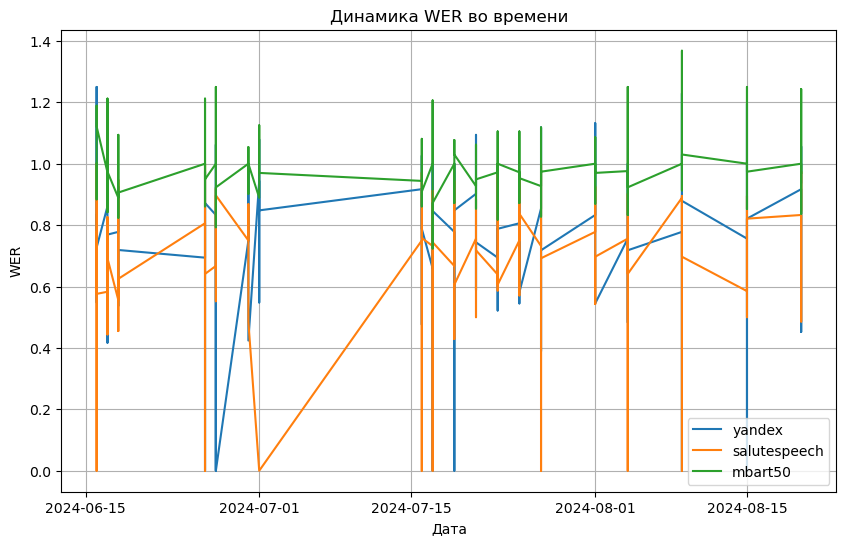

In [200]:
# 1. Динамика метрик во времени (WER)
plt.figure(figsize=(10, 6))
for model in ['yandex', 'salutespeech', 'mbart50']:
    plt.plot(df_filtered.index, df_filtered[f'WER_{model}'], label=model)
plt.title('Динамика WER во времени')
plt.xlabel('Дата')
plt.ylabel('WER')
plt.legend()
plt.grid(True)
plt.show()

In [218]:
plt.figure(figsize=(8, 5))
for model in ['yandex', 'salutespeech', 'mbart50']:
    # Используем правильное имя столбца для каждой модели
    wer_column = f'WER_{model}'
    model_average = df_test_results[df_test_results['Модель'] == model][wer_column].mean()
    plt.bar(model, model_average)
plt.title('Средние значения WER для каждой модели')
plt.xlabel('Модель')
plt.ylabel('Средний WER')
plt.grid(True)
plt.show()

KeyError: 'WER_yandex'

<Figure size 800x500 with 0 Axes>

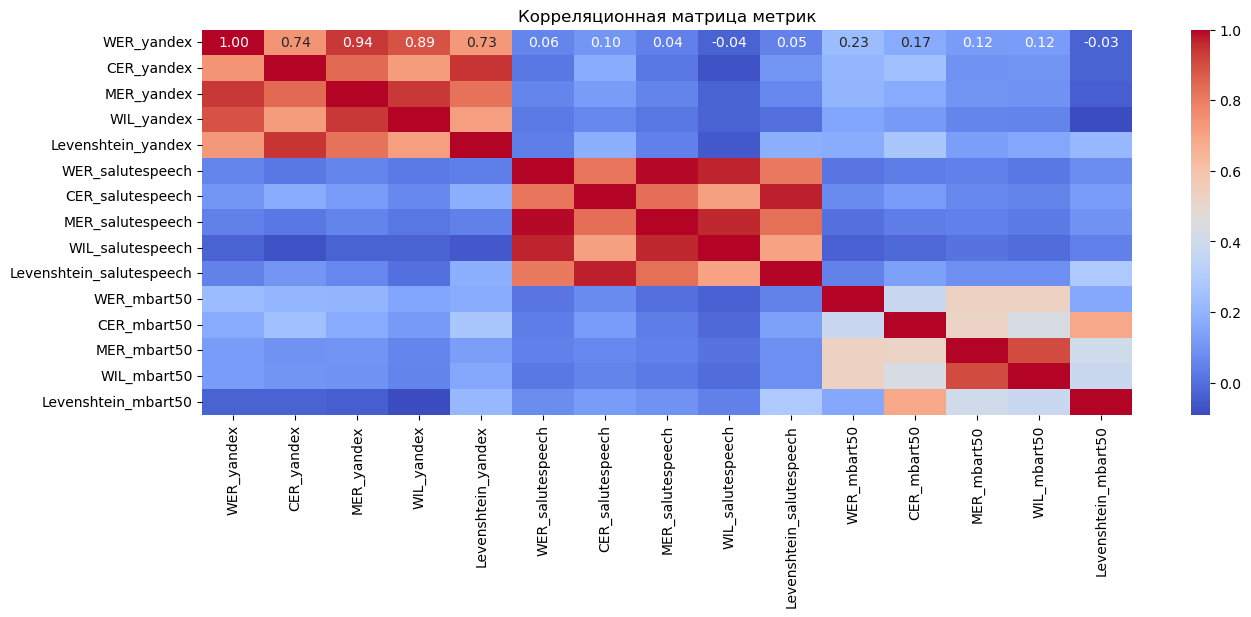

In [217]:
metrics_columns = [col for col in df_filtered.columns if col.startswith(('WER_', 'CER_', 'MER_', 'WIL_', 'Levenshtein_'))]
corr_matrix = df_filtered[metrics_columns].corr()
plt.figure(figsize=(15, 5))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица метрик')
plt.show()